# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl

In [3]:
class preprocess:
    
    paths = {}

    def get_files(folder_path):
        paths = {}
        for path, subdirs, files in os.walk(folder_path):
            for name in files:
                if name.endswith("csv"):
                    key = name.split("_")[0]

                    if paths.get(key) is None:
                        paths[key] = {}

                    if name.endswith("_x.csv"):
                        x = os.path.join(path, name)
                        paths[key]['x'] = x
                    elif name.endswith("_y.csv"):
                        y = os.path.join(path, name)
                        paths[key]['y'] = y
        preprocess.paths = paths
        return paths

    def get_data(paths):
        for key, value in paths.items():
            x = pd.read_csv(value['x'])
            y = pd.read_csv(value['y'])
            #print(x.shape)
            #print(x.values.shape)
            #print(y.sum())
            yield key, x.values, y.values
        
        
    
    
train_paths = preprocess.get_files("dataset/Kyoto2016/2014/01")
test_paths = preprocess.get_files("dataset/Kyoto2016/2015/12")
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/11"))
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/10"))


paths = {}
keys = train_paths.keys()
for key in list(keys)[0:7]:
    paths.update({key: train_paths[key]})
train_paths = paths

print(train_paths)
print("----------------------------------------------------------------------------------------")
#test_paths = test_paths.popitem()
#test_paths = {test_paths[0]: test_paths[1]}
print(test_paths)


{'20140115': {'x': 'dataset/Kyoto2016/2014/01/20140115_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140115_y.csv'}, '20140107': {'y': 'dataset/Kyoto2016/2014/01/20140107_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140107_x.csv'}, '20140109': {'x': 'dataset/Kyoto2016/2014/01/20140109_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140109_y.csv'}, '20140104': {'y': 'dataset/Kyoto2016/2014/01/20140104_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140104_x.csv'}, '20140119': {'x': 'dataset/Kyoto2016/2014/01/20140119_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140119_y.csv'}, '20140120': {'x': 'dataset/Kyoto2016/2014/01/20140120_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140120_y.csv'}, '20140123': {'x': 'dataset/Kyoto2016/2014/01/20140123_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140123_y.csv'}}
----------------------------------------------------------------------------------------
{'20151224': {'y': 'dataset/Kyoto2016/2015/12/20151224_y.csv', 'x': 'dataset/Kyoto2016/2015/12/20151224_x.csv'}, '20151204': {

In [10]:
import tensorflow as tf


In [11]:
class network(object):
    
    input_dim = 42
    classes = 2
    hidden_encoder_dim = 42
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))
            #loss = tf.losses.mean_squared_error(labels = self.y_, predictions = self.y)
            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")
            
        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [12]:
import collections
import time
from sklearn import model_selection as ms
from sklearn import metrics as me

class Train:    
    
    result = namedtuple("score", ['key', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'time_taken'])

    predictions = {}
    results = []
    
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 1000
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_data_temp.values, 
                                                                                  y_data_temp.values, 
                                                                                  test_size=0.1)
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            def train_batch():
                                nonlocal train_loss
                                _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:0.5, net.lr:lr})

                            train_batch()
                            #summary_writer_train.add_summary(summary_str, epoch)
                            #print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                                print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                                net.saver.restore(sess, 
                                                  tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                             .format(epochs,h,f)))
                                train_batch()


                        valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_valid.add_summary(summary_str, epoch)
                    
                        print("Key {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(key, train_loss, valid_accuracy))
                    
                    end_time = time.perf_counter() 
                    for key, x_test, y_test in preprocess.get_data(test_paths):
                        accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                               net.pred, 
                                                                               net.actual, net.y], 
                                                                              feed_dict={net.x: x_test, 
                                                                                         net.y_: y_test, 
                                                                                         net.keep_prob:1, net.lr:lr})
                        
                        
                        f1_score = me.f1_score(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        print("Key {} Test Accuracy: {} F1 score: {}, recall {}, precision {}".format(key, accuracy, f1_score, recall, prec))

                        if accuracy > Train.best_acc_global:
                            Train.best_acc_global = accuracy
                            Train.pred_value = pred_value
                            Train.actual_value = actual_value

                            Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual": actual_value})
                        Train.predictions.update({"{}_{}_{}".format(key,f,h):(curr_pred, 
                                                   Train.result(key, f, h, valid_accuracy, accuracy, f1_score, end_time - start_time))})

                            #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [13]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        print("********************************** Training ******************************")
        Train.predictions = {}
        Train.results = []
    
        
        features_arr = [1, 4, 8, 16, 42]
        hidden_layers_arr = [1, 3]

        epochs = [1]
        lrs = [1e-4]
        print("***************************** Entering Loop **********************")
        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - hidden layers:{} features count:{}".format(h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl'):
            past_scores = df_results#temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

        past_scores.append(df_results, ignore_index=True).to_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [14]:
#%%timeit
Hyperparameters.start_training()

********************************** Training ******************************
***************************** Entering Loop **********************
Current Layer Attributes - hidden layers:1 features count:1
Key 20140115 | Training Loss: 0.508328 | Validation Accuracy: 0.765363
Key 20140107 | Training Loss: 0.496833 | Validation Accuracy: 0.810056
Key 20140109 | Training Loss: 0.490550 | Validation Accuracy: 0.843575
Key 20140104 | Training Loss: 0.586180 | Validation Accuracy: 0.826816
Key 20140119 | Training Loss: 0.434777 | Validation Accuracy: 0.871508
Key 20140120 | Training Loss: 0.508094 | Validation Accuracy: 0.905028
Key 20140123 | Training Loss: 0.414506 | Validation Accuracy: 0.921788
Key 20151224 Test Accuracy: 0.6933549642562866 F1 score: 0.8161100096732256, recall 0.6922981229754882, precision 0.9938524308656053
Key 20151204 Test Accuracy: 0.719265341758728 F1 score: 0.8348292164943242, recall 0.7189905390251603, precision 0.995162821536746
Key 20151216 Test Accuracy: 0.6729779

Key 20151226 Test Accuracy: 0.64101243019104 F1 score: 0.7753146598116044, recall 0.6863092782206377, precision 0.8908457613814756
Key 20151218 Test Accuracy: 0.7202648520469666 F1 score: 0.8346139439770807, recall 0.721101366795727, precision 0.9905404214758865
Key 20151231 Test Accuracy: 0.6848719120025635 F1 score: 0.802463827491512, recall 0.6916928606642495, precision 0.9554787077330268
Key 20151212 Test Accuracy: 0.7405572533607483 F1 score: 0.8484748878196465, recall 0.74257811760698, precision 0.9895984665052462
Key 20151211 Test Accuracy: 0.7188960909843445 F1 score: 0.8349710245731741, recall 0.7183275136538634, precision 0.9968399647136296
Key 20151221 Test Accuracy: 0.6696871519088745 F1 score: 0.7994458270261949, recall 0.6672091131000814, precision 0.9970561884039422
Key 20151201 Test Accuracy: 0.7374376058578491 F1 score: 0.8447177193963108, recall 0.7365818167984669, precision 0.9900672410707437
Key 20151220 Test Accuracy: 0.7124971747398376 F1 score: 0.8261105758697173

Key 20151225 Test Accuracy: 0.5031386017799377 F1 score: 0.6632824597061642, recall 0.4963969508079565, precision 0.9992107970949341
Key 20151210 Test Accuracy: 0.5240436792373657 F1 score: 0.68253825359387, recall 0.5185505082679027, precision 0.9982169457861237
Key 20151217 Test Accuracy: 0.5110123157501221 F1 score: 0.6637516264713893, recall 0.49941453894942267, precision 0.9892853461161796
Key 20151207 Test Accuracy: 0.5764872431755066 F1 score: 0.7187557538048934, recall 0.5612534994249007, precision 0.9991404039135768
Key 20151215 Test Accuracy: 0.4819200038909912 F1 score: 0.6420281835528945, recall 0.47368305426691515, precision 0.9960042498152254
Key 20151213 Test Accuracy: 0.30716460943222046 F1 score: 0.4625709880459399, recall 0.3009957717230854, precision 0.9986469435866786
Key 20151209 Test Accuracy: 0.5108023881912231 F1 score: 0.66866948622538, recall 0.5025303578556988, precision 0.9989164007440146
Key 20151228 Test Accuracy: 0.46322453022003174 F1 score: 0.6277518786

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Key 20151224 Test Accuracy: 0.01711343042552471 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151204 Test Accuracy: 0.013249633833765984 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151216 Test Accuracy: 0.02116244286298752 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151222 Test Accuracy: 0.013258238323032856 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151214 Test Accuracy: 0.015027950517833233 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151202 Test Accuracy: 0.0464799702167511 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151227 Test Accuracy: 0.011802698485553265 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151203 Test Accuracy: 0.09374673664569855 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151223 Test Accuracy: 0.03478793799877167 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151205 Test Accuracy: 0.013487710617482662 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151229 Test Accuracy: 0.02723914012312889 F1 score: 0.0, recall 0.0, precision 0.0
Key 20151208 Test

Key 20151214 Test Accuracy: 0.015044662170112133 F1 score: 3.393266910133568e-05, recall 1.6966622412059877e-05, precision 1.0
Key 20151202 Test Accuracy: 0.04686129093170166 F1 score: 0.0007994945131465268, recall 0.0003999071183467066, precision 1.0
Key 20151227 Test Accuracy: 0.013470728881657124 F1 score: 0.0033702167081288512, recall 0.0016879527373233549, precision 1.0
Key 20151203 Test Accuracy: 0.09379895776510239 F1 score: 0.00012409477295088504, recall 6.205151161914555e-05, precision 0.9333333333333333
Key 20151223 Test Accuracy: 0.034862060099840164 F1 score: 0.00015357523138668196, recall 7.679351248406535e-05, precision 1.0
Key 20151205 Test Accuracy: 0.013524572364985943 F1 score: 7.472864162011695e-05, recall 3.736571695469407e-05, precision 1.0
Key 20151229 Test Accuracy: 0.028569892048835754 F1 score: 0.0027396352308253153, recall 0.001371701647516925, precision 0.9973190348525469
Key 20151208 Test Accuracy: 0.016655471175909042 F1 score: 1.276845680431063e-05, recall

Key 20151203 Test Accuracy: 0.24458743631839752 F1 score: 0.2857023487587737, recall 0.16670138596483453, precision 0.9984602723725079
Key 20151223 Test Accuracy: 0.15146589279174805 F1 score: 0.21624409502727127, recall 0.12127743448233494, precision 0.9967600774215265
Key 20151205 Test Accuracy: 0.09783105552196503 F1 score: 0.15790777530811523, recall 0.08574311069593647, precision 0.9971320557945509
Key 20151229 Test Accuracy: 0.14048925042152405 F1 score: 0.2088072825006686, recall 0.11659464003893863, precision 0.9985158050967885
Key 20151208 Test Accuracy: 0.10235612094402313 F1 score: 0.16071564835087432, recall 0.08740064481118524, precision 0.9972319347319347
Key 20151219 Test Accuracy: 0.38278621435165405 F1 score: 0.18899320754716983, recall 0.10439915952373012, precision 0.9962444302991725
Key 20151206 Test Accuracy: 0.08011144399642944 F1 score: 0.12480450104604637, recall 0.06656843998331591, precision 0.997079107505071
Key 20151225 Test Accuracy: 0.14659301936626434 F1 

In [15]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")


In [16]:
#df_results = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [17]:
#df_results

In [18]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score'].transform(max) == df_results['test_score']
#df_results[idx].sort_values(by = 'test_score', ascending = False)

In [19]:
#df_results.sort_values(by = 'test_score', ascending = False)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [21]:
#plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

In [22]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [23]:
past_scores.sort_values(by='f1_score', ascending = False)

,key,no_of_features,hidden_layers,train_score,test_score,f1_score,time_taken
15,20151210,1,1,0.921788,0.774233,0.871146,20.041186
325,20151210,1,1,0.921788,0.774233,0.871146,20.041186
7,20151203,1,1,0.921788,0.774970,0.861039,20.041186
317,20151203,1,1,0.921788,0.774970,0.861039,20.041186
350,20151205,4,1,0.905028,0.755452,0.859353,15.668566
40,20151205,4,1,0.905028,0.755452,0.859353,15.668566
6,20151227,1,1,0.921788,0.754294,0.858514,20.041186
316,20151227,1,1,0.921788,0.754294,0.858514,20.041186
362,20151228,4,1,0.905028,0.753367,0.858102,15.668566
52,20151228,4,1,0.905028,0.753367,0.858102,15.668566


In [24]:
psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='f1_score', ascending=False)

,,key,train_score,test_score,f1_score,time_taken
no_of_features,hidden_layers,,,,,
1,1,20151210,0.921788,0.774233,0.871146,20.041186
4,1,20151205,0.905028,0.755452,0.859353,15.668566
8,1,20151216,0.882682,0.744721,0.851011,16.062345
42,1,20151228,0.893855,0.736921,0.846989,15.092843
16,1,20151203,0.821229,0.655552,0.765545,14.875491
42,3,20151203,0.754190,0.244587,0.285702,19.912291
4,3,20151221,0.737430,0.040490,0.053660,15.115697
8,3,20151220,0.698324,0.073780,0.025398,15.386132
1,3,20151201,0.765363,0.030448,0.000000,15.611936


In [25]:
#key_nof_hidden '20151201_16_1'
Train.predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")

In [26]:
df = Train.predictions['20151228_42_1'].dropna()

In [27]:
#Train.predictions['20151219_42_1'].loc[:,'Prediction']
df.loc[:,'Prediction'].values.astype(int)

array([0, 1, 1, ..., 0, 0, 1])

In [28]:
from sklearn import metrics as me
me.f1_score(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

0.84698916615638264

In [29]:
df.groupby(by="Actual").Actual.count()

Actual
0.0      4159
1.0    363423
Name: Actual, dtype: int64

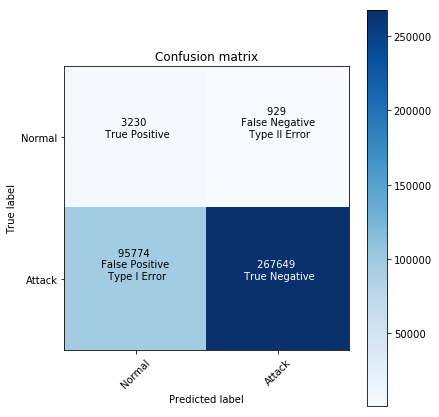

In [30]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [31]:
psg.mean().sort_values(by='f1_score', ascending=False)

,,train_score,test_score,f1_score,time_taken
no_of_features,hidden_layers,,,,
4,1,0.905028,0.708751,0.824990,15.668566
1,1,0.921788,0.699422,0.816935,20.041186
8,1,0.882682,0.693750,0.814542,16.062345
42,1,0.893855,0.657731,0.787330,15.092843
16,1,0.821229,0.537324,0.681770,14.875491
42,3,0.754190,0.133364,0.179698,19.912291
4,3,0.737430,0.041669,0.006952,15.115697
8,3,0.698324,0.039067,0.001683,15.386132
1,3,0.765363,0.038258,0.000000,15.611936


In [32]:
psg.std()

train_score  test_score  f1_score  time_taken
no_of_features hidden_layers                                               
1              1                      0.0    0.059806  0.045952         0.0
               3                      0.0    0.055450  0.000000         0.0
4              1                      0.0    0.038176  0.028825         0.0
               3                      0.0    0.055328  0.012376         0.0
8              1                      0.0    0.040470  0.031042         0.0
               3                      0.0    0.055584  0.004601         0.0
16             1                      0.0    0.067645  0.056637         0.0
               3                      0.0    0.055450  0.000000         0.0
42             1                      0.0    0.041730  0.032684         0.0
               3                      0.0    0.061007  0.046025         0.0

In [33]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


no_of_features  hidden_layers
1               1                   (0.726869908115, 0.906999569347)
                3                                         (nan, nan)
4               1                   (0.768494154497, 0.881485140892)
                3                (-0.0173051632334, 0.0312090055208)
8               1                    (0.75370055604, 0.875382846442)
                3                (-0.00733499693879, 0.010700355621)
16              1                   (0.570762836511, 0.792777409951)
                3                                         (nan, nan)
42              1                   (0.723271051649, 0.851388811447)
                3                  (0.0894908728603, 0.269904941056)
dtype: object